In [30]:
import torch
import datetime
import math
import matplotlib.pyplot as plt
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue 
import warnings
warnings.filterwarnings('ignore')     
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

In [31]:
test_input_10 = torch.Tensor(10, 2*1000, 14*14)
test_target_10 = torch.Tensor(10, 1000)
test_classes_10 = torch.Tensor(10, 2*1000)
for i in range(1,10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
    test_input_10[i,:,:] = test_input.reshape([2000,196])
    test_target_10[i,:] = test_target
    test_classes_10[i,:] = test_classes.reshape([2000])
my_train_input = train_input.reshape([2000,196])
my_train_classes = train_classes.reshape([2000])

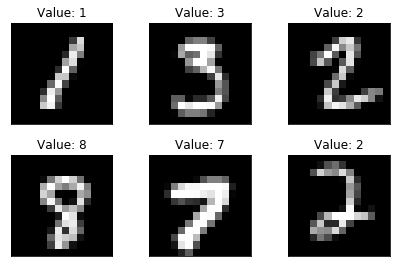

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

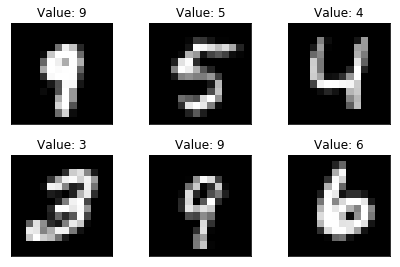

In [4]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [13]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 5
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.004
# hidden size
hidden_size = 100

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_pkeep):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_pkeep) 
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs

In [37]:
def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_,learning_rate_decay):
    start_time = datetime.datetime.now()
    train_error = []
    test_error = []
    # train function
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input_)/batch_size_)):  
            # Move tensors to the configured device
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_))
        test_ = []
        for i in range(1,10):
            test_.append(test_accuracy(model_, test_input_10[i,:,:], test_classes_10[i,:]))
        test_error.append(sum(test_) / len(test_))
    end_time = datetime.datetime.now()
    training_time = end_time - start_time
    print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}, avg test error on 10 different samples: {:.5f}'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [7]:
def test_accuracy(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions.long() == my_test_classes_.long()).sum().item()

    return 1 - well_predicted_count / total

# Testing influence of hidden size

In [110]:
hidden_size = [10, 50, 100, 200, 500, 1000, 2000]
train_error_HS = [[],[],[],[],[],[],[]]
test_error_HS = [[],[],[],[],[],[],[]]
idx = 0
for HS in hidden_size:
    print("Hidden size = " + HS)
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, HS, num_class, 1).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_HS[idx], test_error_HS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

Loss: 2.2313 on epoch: 1, train error: 0.83550, test error: 0.82900
Loss: 0.9724 on epoch: 25, train error: 0.69350, test error: 0.69300
Loss: 1.7154 on epoch: 1, train error: 0.31500, test error: 0.35100
Loss: 0.2786 on epoch: 25, train error: 0.06350, test error: 0.15950
Loss: 1.1774 on epoch: 1, train error: 0.17400, test error: 0.21000
Loss: 0.0001 on epoch: 25, train error: 0.00000, test error: 0.08950
Loss: 1.0984 on epoch: 1, train error: 0.10900, test error: 0.16800
Loss: 0.0010 on epoch: 25, train error: 0.00000, test error: 0.08050
Loss: 1.2924 on epoch: 1, train error: 0.09150, test error: 0.15050
Loss: 0.0007 on epoch: 25, train error: 0.00000, test error: 0.07300
Loss: 0.7121 on epoch: 1, train error: 0.12300, test error: 0.19600
Loss: 0.0002 on epoch: 25, train error: 0.00000, test error: 0.07650
Loss: 0.5262 on epoch: 1, train error: 0.08800, test error: 0.15650
Loss: 0.0002 on epoch: 25, train error: 0.00000, test error: 0.06700


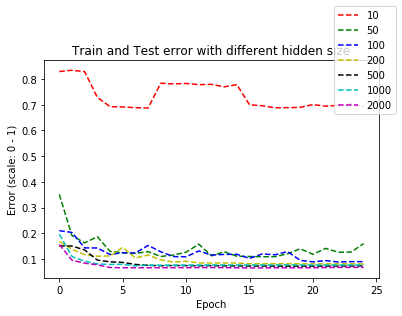

In [114]:
plt.plot(test_error_HS[0],'r--', label='10')
plt.plot(test_error_HS[1], 'g--', label='50')
plt.plot(test_error_HS[2], 'b--', label='100')
plt.plot(test_error_HS[3], 'y--', label='200')
plt.plot(test_error_HS[4], 'k--', label='500')
plt.plot(test_error_HS[5], 'c--', label='1000')
plt.plot(test_error_HS[6], 'm--', label='2000')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different hidden size")
plt.show()

# Testing influence of Batch Size

In [116]:
hidden_size = 500
batch_size = [2, 5, 20, 50, 100]
train_error_BS = [[],[],[],[],[]]
test_error_BS = [[],[],[],[],[]]
idx = 0
for BS in batch_size:
    print("Batch size = " + BS)
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, 1).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_BS[idx], test_error_BS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,BS,LRD)
    idx += 1

Loss: 0.0008 on epoch: 1, train error: 0.82050, test error: 0.84150
Loss: 2.0633 on epoch: 25, train error: 0.87400, test error: 0.88400
Loss: 1.0184 on epoch: 1, train error: 0.12650, test error: 0.19650
Loss: 0.0004 on epoch: 25, train error: 0.00000, test error: 0.07900
Loss: 0.4212 on epoch: 1, train error: 0.06350, test error: 0.13950
Loss: 0.0013 on epoch: 25, train error: 0.00000, test error: 0.09200
Loss: 0.3600 on epoch: 1, train error: 0.10050, test error: 0.18800
Loss: 0.0051 on epoch: 25, train error: 0.00000, test error: 0.11400
Loss: 0.6183 on epoch: 1, train error: 0.15550, test error: 0.22650
Loss: 0.0086 on epoch: 25, train error: 0.00000, test error: 0.09950


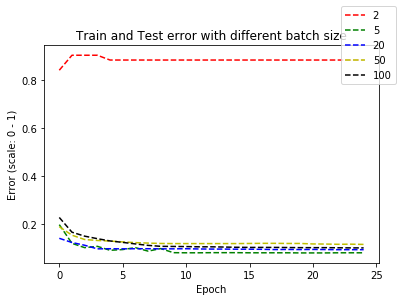

In [117]:
plt.plot(test_error_BS[0],'r--', label='2')
plt.plot(test_error_BS[1], 'g--', label='5')
plt.plot(test_error_BS[2], 'b--', label='20')
plt.plot(test_error_BS[3], 'y--', label='50')
plt.plot(test_error_BS[4], 'k--', label='100')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different batch size")
plt.show()

# Testing the influence of learning rate decay

In [38]:
learning_rate_decay = [False, True]
train_error_LRD = [[],[]]
test_error_LRD = [[],[]]
time_to_train_LRD = [[],[]]
idx = 0
for LRD in learning_rate_decay:    
    print("learning rate = " + str(LRD))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, 1).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_LRD[idx], test_error_LRD[idx], time_to_train_LRD[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

learning rate = False
Loss: 0.0008 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07222
learning rate = True
Loss: 0.0067 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07628


In [45]:
for i in range(len(time_to_train_LRD)):
    print(time_to_train_LRD[0].seconds)

19
19


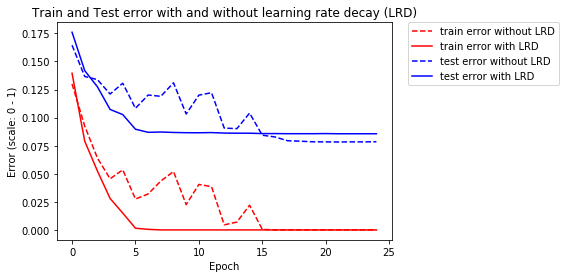

In [29]:
plt.plot(train_error_LRD[0], 'r--', label='train error without LRD')
plt.plot(train_error_LRD[1], 'r', label='train error with LRD')
plt.plot(test_error_LRD[0], 'b--', label='test error without LRD')
plt.plot(test_error_LRD[1], 'b', label='test error with LRD')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Train and Test error with and without learning rate decay (LRD)")
plt.show()

# Testing regularization technique: Dropout

In [80]:
dropout = [0, 0.25, 0.50, 0.75, 0.100]
idx = 0
train_error_dropout = [[],[],[],[],[]]
test_error_dropout = [[],[],[],[],[]]
for dropout_ in dropout:
    print("Dropout= " + dropout_)
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, dropout_).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_dropout[idx], test_error_dropout[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,True)
    idx += 1

Loss: 0.6642 on epoch: 1, train error: 0.11300, test error: 0.15650
Loss: 0.0183 on epoch: 10, train error: 0.00000, test error: 0.08900
Loss: 0.0139 on epoch: 20, train error: 0.00000, test error: 0.08750
Loss: 1.1116 on epoch: 1, train error: 0.20650, test error: 0.25400
Loss: 0.0053 on epoch: 10, train error: 0.00000, test error: 0.08600
Loss: 0.0040 on epoch: 20, train error: 0.00000, test error: 0.08550
Loss: 1.6475 on epoch: 1, train error: 0.10300, test error: 0.15900
Loss: 0.0107 on epoch: 10, train error: 0.00000, test error: 0.08050
Loss: 0.0081 on epoch: 20, train error: 0.00000, test error: 0.08050
Loss: 1.8677 on epoch: 1, train error: 0.19450, test error: 0.23100
Loss: 0.0082 on epoch: 10, train error: 0.00000, test error: 0.08750
Loss: 0.0065 on epoch: 20, train error: 0.00000, test error: 0.08900
Loss: 1.5917 on epoch: 1, train error: 0.13200, test error: 0.17800
Loss: 0.0092 on epoch: 10, train error: 0.00000, test error: 0.09000
Loss: 0.0075 on epoch: 20, train error:

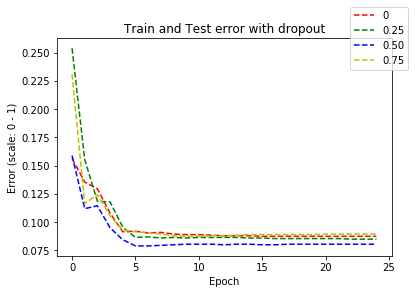

In [102]:
plt.plot(test_error_dropout[0],'r--', label='0')
plt.plot(test_error_dropout[1], 'g--', label='0.25')
plt.plot(test_error_dropout[2], 'b--', label='0.50')
plt.plot(test_error_dropout[3], 'y--', label='0.75')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with dropout")
plt.show()

# Let's try regularization: dropout

In [37]:
#as we got 100% on the train error it seems that we just leared by heart the train dataset
# let's adding regularization:
class NeuralNet_reg(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_reg, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, hidden_size)  
        self.layer4 = nn.Linear(hidden_size, num_class)  
        self.dropout = nn.Dropout(0.8)
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer4(outputs)
        return outputs
# creating neural net
model_reg = NeuralNet_reg(input_size, hidden_size, num_class).to(device)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = torch.optim.SGD(model_reg.parameters(), lr=learning_rate) 

train_error, test_error = train_model(model_reg, my_train_input, my_train_classes, criterion_reg, optimizer_reg, num_epochs, batch_size)

Loss: 0.8557 on epoch: 1, train error: 0.11150, test error: 0.18200
Loss: 0.0120 on epoch: 5, train error: 0.00300, test error: 0.07950
Loss: 0.0056 on epoch: 10, train error: 0.00000, test error: 0.07250
Loss: 0.0033 on epoch: 15, train error: 0.00000, test error: 0.07150
Loss: 0.0022 on epoch: 20, train error: 0.00000, test error: 0.07150
Loss: 0.0016 on epoch: 25, train error: 0.00000, test error: 0.07150


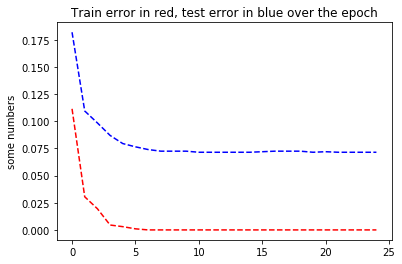

In [38]:
plt.plot(train_error, 'r--', test_error, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

# Testing on the 2 batches
A model for the two batch of 1000 images

In [39]:
my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

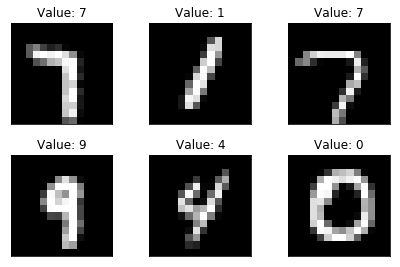

In [40]:
# verifying the digits and labels
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(my_test_input2[i], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(my_test_classes2[i]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [41]:
my_test_input1=my_test_input1.reshape(1000,196)
my_test_input2=my_test_input2.reshape(1000,196)

In [42]:
print("Error on batch 1: {}".format(test_accuracy(model, my_test_input1, my_test_classes1)))
print("Error on batch 2: {}".format(test_accuracy(model, my_test_input2, my_test_classes2)))

Error on batch 1: 0.08299999999999996
Error on batch 2: 0.08599999999999997


# Building neural net for Digit Comparison

In [43]:
# number of epoch
num_epochs_dc = 21
# batch size to compute mini-batch
batch_size_dc = 10
# number of pixels in the image 
input_size_dc = 2
# number of possible digit: 0 to 9 
num_class_dc = 1
# small step to find a minima
learning_rate_dc = 0.004
# hidden size
hidden_size_dc = 200

# Fully connected neural network with one hidden layer
class NeuralNet_dc(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_dc, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x, batch_size_):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs.reshape([1, batch_size_])[0]
        
    
# creating neural net
model_dc = NeuralNet_dc(input_size_dc, hidden_size_dc, num_class_dc).to(device)

# MSELoss and optimizer which minimize loss with learning rate step
criterion_dc = nn.MSELoss()
optimizer_dc = torch.optim.SGD(model_dc.parameters(), lr=learning_rate_dc)  

# train function
for epoch in range(num_epochs_dc):
    for i in range(int(len(train_classes)/batch_size_dc)):  
        # Move tensors to the configured device
        inputs = train_classes.narrow(0,i*batch_size_dc,batch_size_dc).to(device).float()
        labels = train_target.narrow(0,i*batch_size_dc,batch_size_dc).to(device)

        # Forward pass
        outputs = model_dc(inputs,batch_size_dc)
        loss = criterion_dc(outputs, labels.float())
        
        # Backward and optimize
        optimizer_dc.zero_grad()
        loss.backward()
        optimizer_dc.step()
    if(epoch % 5 == 0):    
        print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch+1))

Loss: 0.1127 on epoch: 1
Loss: 0.0278 on epoch: 6
Loss: 0.0171 on epoch: 11
Loss: 0.0134 on epoch: 16
Loss: 0.0110 on epoch: 21


In [44]:
# test function
def test_accuracy_dc(model_, my_test_input_, my_test_classes_):

    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float(),total)
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, test_classes, test_target)


Accuracy: 100.0 %


# Running both neural networks in sequence

In [45]:
# test function
def getting_y(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions == my_test_classes_).sum().item()

    print('Accuracy: {} %'.format(100 * well_predicted_count / total))
    return predictions

y1 = getting_y(model_reg, my_test_input1, my_test_classes1)
y2 = getting_y(model_reg, my_test_input2, my_test_classes2)
y_test_classes = torch.tensor([y1.tolist(), y2.tolist()]).transpose_(0, 1)
y_test_classes

Accuracy: 93.4 %
Accuracy: 92.3 %


tensor([[0, 7],
        [4, 1],
        [8, 7],
        ...,
        [5, 3],
        [5, 6],
        [7, 4]])

In [46]:
# test function
def digit_comparison(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float())
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, y_test_classes, test_target)

Accuracy: 95.4 %
